In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import networkx as nx
import community as lv
from konlpy.tag import Okt
okt = Okt()

In [2]:
#setting plt font & size

plt.rcParams["font.family"] = "Hancom MalangMalang"
plt.rcParams['figure.figsize'] = 10,10
sns.set(font="Hancom MalangMalang", rc={"axes.unicode_minus":False}, style='white')

In [3]:
df = pd.read_excel("./coinpan.xlsx", engine = 'openpyxl')

# 단어 네트워크 분석

In [19]:
title_lis = []

for i in range(len(df)): 
    texts = okt.phrases(df['제목'][i])
    text_list = [k for k in texts if len(k) > 1] 
    title_lis.append(text_list)
    
df['키워드'] = title_lis

In [20]:
edge_list = []
for text in df['키워드']:
    num_text = len(text)
    if num_text > 0:
        for i in range(num_text-1):
            for j in range(i+1, num_text):
                edge_list += [tuple(sorted([text[i], text[j]]))]
edges = list(Counter(edge_list).items())

In [21]:
real_edges = []
for i in range(len(edges)):
    if edges[i][1] >=3 :
        real_edges.append(edges[i])        

In [22]:
G = nx.Graph((x, y, {'weight': v}) for (x, y), v in real_edges)

partition = lv.best_partition(G)
nx.set_node_attributes(G, partition, "community") 

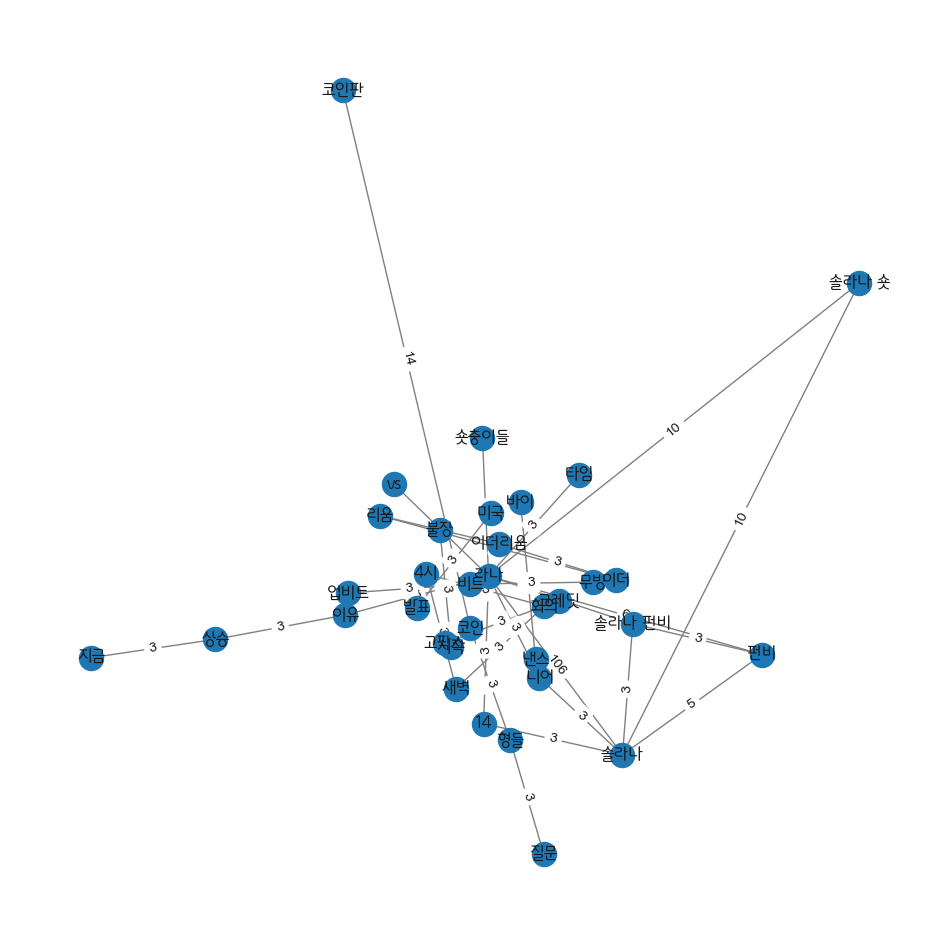

In [23]:
plt.figure(figsize=(12,12))

weight = nx.get_edge_attributes(G, 'weight')

sp = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, sp, edge_color='grey', font_family='Hancom MalangMalang')
nx.draw_networkx_edge_labels(G, sp, edge_labels=weight)

plt.axis('off')
plt.show()

# LDA

In [25]:
texts = df['키워드'].tolist()

In [26]:
import gensim as g
coin_dict = g.corpora.Dictionary(texts)
corpus = [coin_dict.doc2bow(i) for i in texts]

In [27]:
perplexity = []
for i in range(2,20):
    ldamodel = g.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    perplexity.append(ldamodel.log_perplexity(corpus))

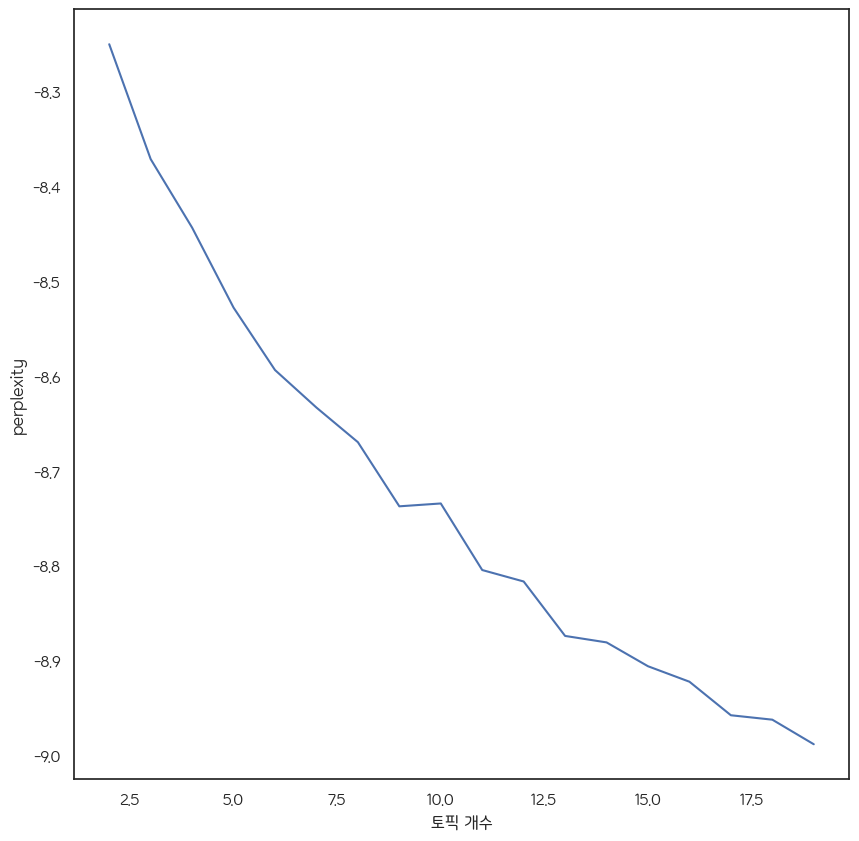

In [28]:
x = range(2,20)
plt.plot(x,perplexity)
plt.xlabel("토픽 개수")
plt.ylabel("perplexity")
plt.show()

In [29]:
coherence = []
for i in range(2,20):
    ldamodel = g.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    coherence_mo_lda = g.models.CoherenceModel(model = ldamodel, texts = texts, dictionary = coin_dict) 
    coherence_lda = coherence_mo_lda.get_coherence()
    coherence.append(coherence_lda)

In [ ]:
x = range(2,20)
plt.plot(x,coherence)
plt.xlabel("토픽 개수")
plt.ylabel("coherence")
plt.show()

In [ ]:
NUM_TOPICS = coherence.index(max(coherence))
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=coin_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, coin_dict, mds='mmds')
pyLDAvis.display(vis)

In [ ]:
pyLDAvis.save_html(vis, 'coinpan_LDA.html')